# Differential Privacy Introduction

This document illustrates the basic and essential concepts and features associated with differential privacy (DP) by considering an example use case drawn from the advertising technology domain. This example simplifies many details and is inspired by an [Ad Tech Explained article](https://adtechexplained.com/interoperable-private-attribution-ipa-explained/).

## Dependencies

The code blocks in this document rely on [Matplotlib](https://matplotlib.org/) and [NumPy](https://numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Example Use Case: Attribution in Digital Advertising

In this example, a **publisher** operates a website on which users view content after logging in using their email address. This website also displays advertisements from a **vendor**. The publisher records **source events** (impressions and clicks) associated with each email address.

When a user clicks an advertisement, they visit the vendor's website can have the option to log in with their email address and make a purchase. The vendor website records **trigger events**: purchases of products associated with a user's email address.

![Digital advertising attribution workflow diagram.](advertising-attribution-workflow-diagram.png)

Source and trigger events are submitted to an **attribution service** that matches them up by email address. This can be either a trusted service such as a clean room or an ensemble of organizations running a secure multi-party computation protocol (as in the [Interoperable Private Attribution](https://eprint.iacr.org/2023/437) protocol). The exact manner in which this is accomplished is not important for understanding the basics of DP (but any such organization or infrastructure can support DP queries against the matched data).

## Querying and Risks

A publisher might select a **set of recorded source events** and request the **count of conversion events** from the attribution service. Define a *query* $Q$ from the publisher to be a set of source event identifiers. Define a *reply* from an attribution service to be a count (which may be approximate) of the total number of matching conversion events.

In [2]:
trigger_events = {
    'alice@web.com',
    'bob@web.com',
    'carla@web.com',
    'dan@web.com',
    'eve@web.com',
    'frank@web.com',
    'gina@web.com'
}

def attribution_service(query):
    return sum([1 for e in trigger_events if e in query])

If the publisher is allowed to make any number of queries of any size to the attribution service, they could submit queries containing individual source event records to learn exactly which individual users' clicks led to conversions (and, potentially, the those individual users' interests and purchasing history).

Even with a limited number of queries, the publisher could submit two queries $Q_1$ and $Q_2$ that differ by exactly one record $\langle\texttt{alice@example.com}, ...\rangle$. The difference between the two replies can then reveal whether Alice's individual click led to a conversion.

In [3]:
trigger_events = {
    'alice@web.com',
    'bob@web.com',
    'carla@web.com',
    'dan@web.com',
    'eve@web.com',
    'frank@web.com',
    'gina@web.com'
}

def attribution_service(query):
    return sum([1 for e in trigger_events if e in query])

print(attribution_service({'alice@web.com', 'bob@web.com', 'carla@web.com'}))
print(attribution_service({'bob@web.com', 'carla@web.com'}))

3
2


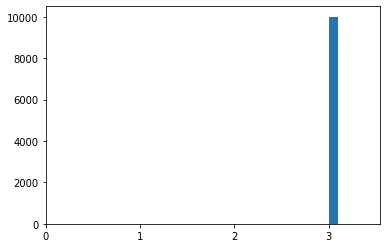

In [63]:
plt.hist([
    attribution_service({'alice@web.com', 'bob@web.com', 'carla@web.com'})
    for _ in range(10000)
])
plt.xticks(np.arange(0, 4, step=1))
plt.show()

Below, we plot the possible differences for this basic version of the service. Unsurprisingly, the difference is always the same.

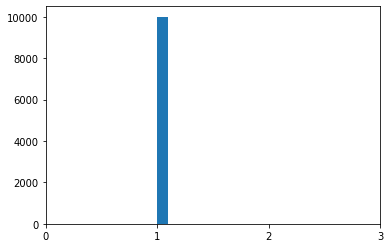

In [4]:
def diffs(n):
    return [
        (
            attribution_service({'alice@web.com', 'bob@web.com', 'carla@web.com'})
            -
            attribution_service({'bob@web.com', 'carla@web.com'})
        )
        for _ in range(n)
    ]

plt.hist(diffs(10000))
plt.xticks(np.arange(0, 4, step=1))
plt.show() 

## Differentially Private Aggregation

To address the publisher's ability to learn about its individual users' conversion histories, the attribution service can instead return *differentially private* counts in its replies.

As an example, suppose that instead of returning $1$ for every trigger event that is found in the query, the attribution service returns $1$ with a $60\%$ probability and $0$ with a $40\%$ probability.

In [5]:
from random import choice

def attribution_service(query):
    return sum([choice([1, 1, 1, 0, 0]) for e in trigger_events if e in query])

In this case, the same queries do not yield the same result every time. The distribution of results for $10,000$ instances of the query `{'alice@web.com', 'bob@web.com', 'carla@web.com'}` is plotted below.

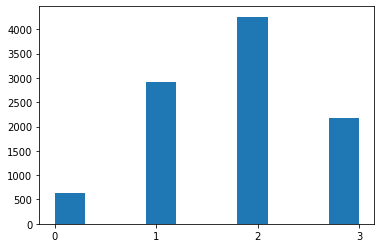

In [6]:
plt.hist([
    attribution_service({'alice@web.com', 'bob@web.com', 'carla@web.com'})
    for _ in range(10000)
])
plt.xticks(np.arange(0, 4, step=1))
plt.show() 

However, with enough pairs of queries, the difference becomes easier to discern.

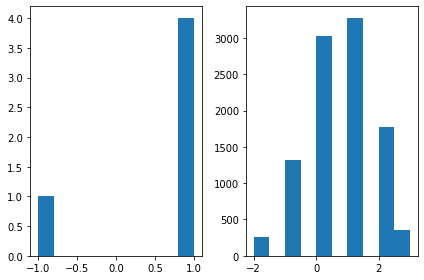

In [7]:
(fig, axs) = plt.subplots(1, 2, sharey=False, tight_layout=True)
_ = axs[0].hist(diffs(5))
_ = axs[1].hist(diffs(10000))

We can aggregate how often each possible difference appears when only $5$ pairs of queries are allowed vs. when $10000$ pairs of queries are allowed.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.53it/s]


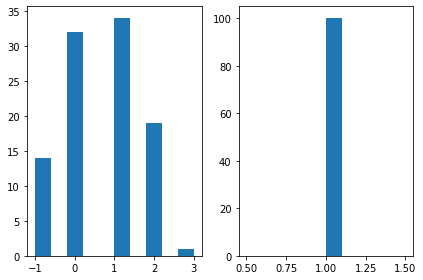

In [8]:
from collections import Counter
from tqdm import tqdm

def diff_counts(n):
    counts = []
    for _ in tqdm(range(100)):
        c = Counter(diffs(n)).most_common()[0][0]
        counts.append(c)
    return counts

(fig, axs) = plt.subplots(1, 2, sharey=False, tight_layout=True)
_ = axs[0].hist(diff_counts(5))
_ = axs[1].hist(diff_counts(10000))